In [1]:
# Populating the interactive namespace from numpy, matplotlib, math, pyproj
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import *
import pyproj
geod = pyproj.Geod(ellps="WGS84")

In [2]:
# input: longitudes of Hellenic arc (approximate)
lon = np.array([19.8686076, 20.00207124, 20.12339917, 20.23262055, 20.34187112, 20.46322822, 20.57242043, 
                20.68161265, 20.80294058, 20.92418099, 21.03331486, 21.17879751, 21.28798973, 21.40925931, 
                21.51842236, 21.6275854, 21.74885498, 21.87015374, 21.99142332, 22.11266373, 22.2459815, 
                22.35505703, 22.47632661, 22.59756702, 22.71886578, 22.85230024, 22.97362817, 23.10709181, 
                23.20417748, 23.32547624, 23.32547624, 23.48312378, 23.61652907, 23.74987602, 23.87111643, 
                24.0044342, 24.14988769, 24.27109892, 24.42862977, 24.57399574, 24.71936171, 24.87686339, 
                25.03436506, 25.20391493, 25.36135827, 25.5188016, 25.65197351, 25.80927098, 25.93021967, 
                26.05113918, 26.18413606, 26.31716211, 26.4622947, 26.58321421, 26.71626944, 26.8614312, 
                27.00662213, 27.13964818, 27.27273258, 27.39368126, 27.51460078, 27.63552029, 27.75641063, 
                27.84095219, 27.90128067, 27.96157998, 28.00977275, 28.04585898, 28.08194521, 28.13013799, 
                28.19046647, 28.26290148, 28.34741387, 28.43195542, 28.51652615, 28.60109688, 28.68566761])

In [3]:
# input: latitudes of Hellenic arc (approximate)
lat = np.array([37.91566265, 37.79518072, 37.68674699, 37.57831325, 37.45783133, 37.3373494, 37.24096386, 
                 37.14457831, 37.03614458, 36.96385542, 36.89156627, 36.80722892, 36.71084337, 36.62650602, 
                 36.54216867, 36.45783133, 36.37349398, 36.27710843, 36.19277108, 36.12048193, 36.06024096, 
                 36.01204819, 35.92771084, 35.85542169, 35.75903614, 35.65060241, 35.54216867, 35.42168675, 
                 35.3253012, 35.22891566, 35.22891566, 35.12048193, 35.02409639, 34.95180723, 34.87951807, 
                 34.81927711, 34.74698795, 34.68674699, 34.62650602, 34.59036145, 34.55421687, 34.5060241, 
                 34.45783133, 34.43373494, 34.40963855, 34.38554217, 34.38554217, 34.42168675, 34.46987952, 
                 34.53012048, 34.60240964, 34.6626506, 34.72289157, 34.78313253, 34.8313253, 34.87951807, 
                 34.91566265, 34.97590361, 35.01204819, 35.06024096, 35.12048193, 35.18072289, 35.25301205, 
                 35.3373494, 35.42168675, 35.51807229, 35.61445783, 35.71084337, 35.80722892, 35.90361446, 
                 35.98795181, 36.07228916, 36.1686747, 36.25301205, 36.3253012, 36.39759036, 36.46987952])

In [6]:
def create_subfaults(lon, lat, D, W, nlayers):
    """
    Calculates the coordinates and the strike angles of subfaults with
    length D along the fault and width W perpendicular to the fault.
    As an input receives vectors of coordinates (in degrees) of the fault
    (longitude and latitude, respectfully; sorted by ascending longitude), 
    the length and the width of the subfault (in meters) and the desired 
    number of the subfault layers (in the direction perpendicular to the fault).
    """
    
    n = len(lon) - 2
    p1 = lon[0]
    p2 = lat[0]
    lons2 = []
    lats2 = []
    strike = []
    i = 0
    d = D/2
    
    while True:
        # calculate distance and angles from current position to the next point along the fault
        az1, az2, dist = geod.inv(p1, p2, lon[i + 1], lat[i + 1], radians=False)
        
        # if the distance to the next point is greater than the required distance
        if dist > d:
            
            # calculate coordinates of the point on the fault at the required distance 
            # in the direction of the next point
            p1, p2, backaz = geod.fwd(p1, p2, az1, d, radians=False)
            
            # save the coordinates and the strike angle of the subfault
            lons2.append(p1)
            lats2.append(p2)
            strike.append(az2)
            d = D
            
        # if the distance to the next point is smaller than the required distance    
        else:
            
            # move the current position to the next point and calculate the remaining 
            # distance
            d = d - dist
            i = i + 1 
            p1 = lon[i]
            p2 = lat[i]
            
        if i > n:
            break
            
    # when more than one layer are required
    if nlayers > 1:
        
        # find the number of subfaults in each layer
        len_layer = len(lons2)
        
        # for each layer
        for j in range(2, nlayers + 1):
            
            # for each subfault in the layer
            for i in range(len_layer):
                
                # calculate coordinates of the subfault at the required distance 
                #from the previous layer perpendicular to the fault
                b = i + len_layer*(j - 2)
                dlons2, dlats2, backaz = geod.fwd(lons2[b], lats2[b], strike[b] + 90, W, radians=False)
                
                # save the coordinates and the strike angle of the subfault
                lons2.append(dlons2)
                lats2.append(dlats2)
                strike.append(strike[b])
                
    return lons2, lats2, strike

In [132]:
# calculating coordinates and strike angles of subfaults (20 km of length, 20 km of width, 2 layers)
[lons2, lats2, strike] = create_subfaults(lon, lat, 20000, 20000, 2)

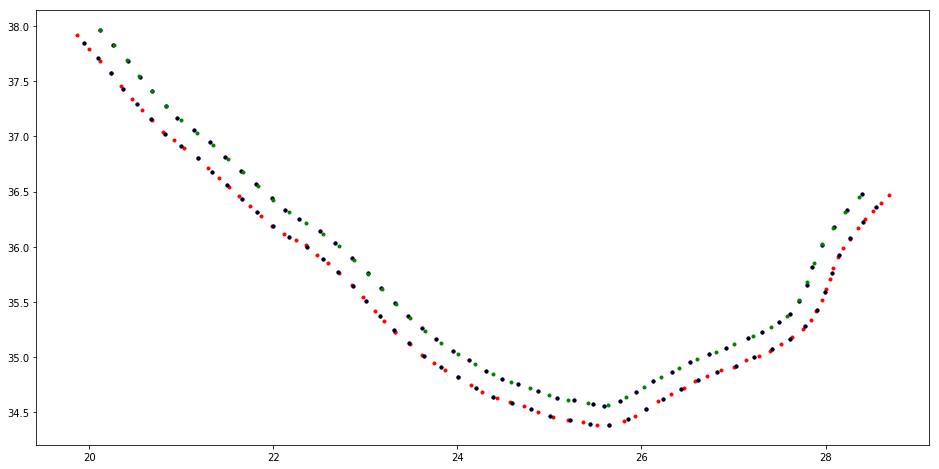

In [33]:
# plotting the scatter plot of the fault and the locations of 2 layers of the subfaults
plt.figure(figsize=(16, 8))
plt.plot(lon, lat, 'r.')
plt.plot(lons3, lats3, 'b.')
plt.plot(lons2, lats2, 'k.')
plt.plot(dummy_lons2, dummy_lats2, 'k.')
plt.plot(dummy_lons3, dummy_lats3, 'g.')

In [4]:
D = 20000
W = 20000

In [77]:
# definitions for the first layer of subfaults
n = len(lon) - 2
p1 = lon[0]
p2 = lat[0]
lons2 = []
lats2 = []
strike = []
i = 0
d = D/2

In [78]:
# calculating locations of the first row of the subfaults

while True:
    # calculate distance and angles from current position to the next point along the fault
    az1, az2, dist = geod.inv(p1, p2, lon[i + 1], lat[i + 1], radians=False)
        
    # if the distance to the next point is greater than the required distance
    if dist > d:
            
        # calculate coordinates of the point on the fault at the required distance 
        # in the direction of the next point
        p1, p2, backaz = geod.fwd(p1, p2, az1, d, radians=False)
            
         # save the coordinates and the strike angle of the subfault
        lons2.append(p1)
        lats2.append(p2)
        strike.append(az2)
        d = D
            
    # if the distance to the next point is smaller than the required distance    
    else:
            
        # move the current position to the next point and calculate the remaining 
        # distance
        d = d - dist
        i = i + 1 
        p1 = lon[i]
        p2 = lat[i]
            
    if i > n:
        break

In [79]:
# length of the first layer
len_layer = len(lons2)

In [80]:
dummy_lons2 = []
dummy_lats2 = []
dummy_strike = []

In [17]:
j = 2

In [18]:
# calculating the coordinates of the points at the required distance 
# from the first layer perpendicular to the first layer
for i in range(len_layer):
                
    # calculate coordinates of the points at the required distance 
    # from the previous layer perpendicular to the first layer
    b = i + len_layer*(j - 2)
    dlons2, dlats2, backaz = geod.fwd(lons2[b], lats2[b], strike[b] + 90, W, radians=False)
                
    # save the coordinates and the strike angle of the subfault
    dummy_lons2.append(dlons2)
    dummy_lats2.append(dlats2)
    dummy_strike.append(strike[b])

In [26]:
dummy_lons3 = []
dummy_lats3 = []
dummy_strike3 = []

In [28]:
# definitions for the second layer of subfaults
n = len(dummy_lons2) - 2
p1 = dummy_lons2[0]
p2 = dummy_lats2[0]
i = 0
d = D
dummy_lons3.append(p1)
dummy_lats3.append(p2)
dummy_strike3.append(dummy_strike[0])

In [29]:
# calculating locations of the second row of the subfaults

while True:
    # calculate distance and angles from current position to the next point along the fault
    az1, az2, dist = geod.inv(p1, p2, dummy_lons2[i + 1], dummy_lats2[i + 1], radians=False)
        
    # if the distance to the next point is greater than the required distance
    if dist > d:
            
        # calculate coordinates of the point on the fault at the required distance 
        # in the direction of the next point
        p1, p2, backaz = geod.fwd(p1, p2, az1, d, radians=False)
            
         # save the coordinates and the strike angle of the subfault
        dummy_lons3.append(p1)
        dummy_lats3.append(p2)
        dummy_strike3.append(az2)
        d = D
            
    # if the distance to the next point is smaller than the required distance    
    else:
            
        # move the current position to the next point and calculate the remaining 
        # distance
        d = d - dist
        i = i + 1 
        p1 = dummy_lons2[i]
        p2 = dummy_lats2[i]
            
    if i > n:
        break

In [27]:
dummy_strike[0]

-41.25223977091855

In [30]:
len(lons2)

52

In [31]:
len(dummy_lons3)

50

In [32]:
len(dummy_lons2)

52

In [70]:
lons2[101]

28.35964111340779

In [51]:
# adding the second row to the first row
lons2.extend(dummy_lons3)
lats2.extend(dummy_lats3)
strike.extend(dummy_strike3)

In [72]:
len(lons2) - len(dummy_lons3)

52

In [50]:
strike = strike[0:52]
lats2 = lats2[0:52]

In [109]:
len(strike)

52

In [133]:
# defining parameters of each subfault (in the example all parameters are uniformely distributed and do not 
# describe a real earthquake, they are used only for plotting the subfaults)
depth = 5*np.ones(len(lons2))
length = 20*np.ones(len(lons2))
width = 20*np.ones(len(lons2))
dip = 15*np.ones(len(lons2))
rake = 90*np.ones(len(lons2))
slip = 10*np.ones(len(lons2))

In [134]:
# writing the subfaults parameters in the csv file suitable for Geoclaw
with open("hellenicarc.csv", "w") as f:
    f.write("Longitude,Latitude,Depth,Length,Width,Strike,Dip,Rake,Slip\n")
    for long, latt, d, l, w, st, dipp, r, sl in zip(lons2, lats2, depth, length, width, strike, dip, rake, slip):
        f.write("{:.7},{:.7},{},{},{},{:.6},{},{},{}".format(long, latt, d, l, w, st, dipp, r, sl))
        f.write("\n")

In [135]:
# reading the csv file from Geoclaw
from clawpack.geoclaw import dtopotools, fgmax_tools
import os
CLAW = os.environ['CLAW']
subfault_fname = 'hellenicarc.csv'
input_units = {"length":"km", "width":"km", "depth":"km", "slip":"m"}
fault = dtopotools.CSVFault()
fault.read(subfault_fname, input_units=input_units)

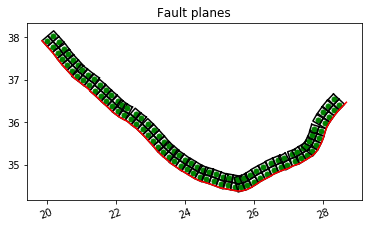

In [66]:
# creating and plotting subfaults in Geoclaw
fault.plot_subfaults(plot_rake=True)
plt.plot(lon, lat, 'r')

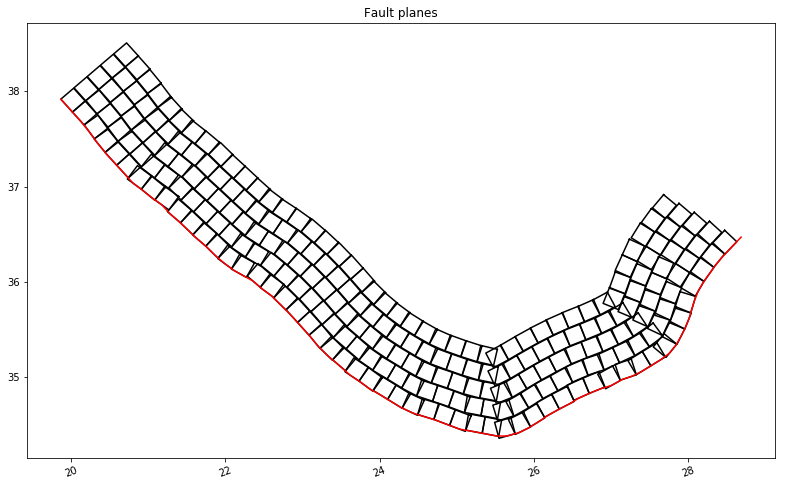

In [158]:
# creating and plotting subfaults in Geoclaw with the correction of overlapping
_, axes = plt.subplots(figsize=(16, 8))
fault.plot_subfaults(axes=axes, plot_rake=False)
plt.plot(lon, lat, 'r')

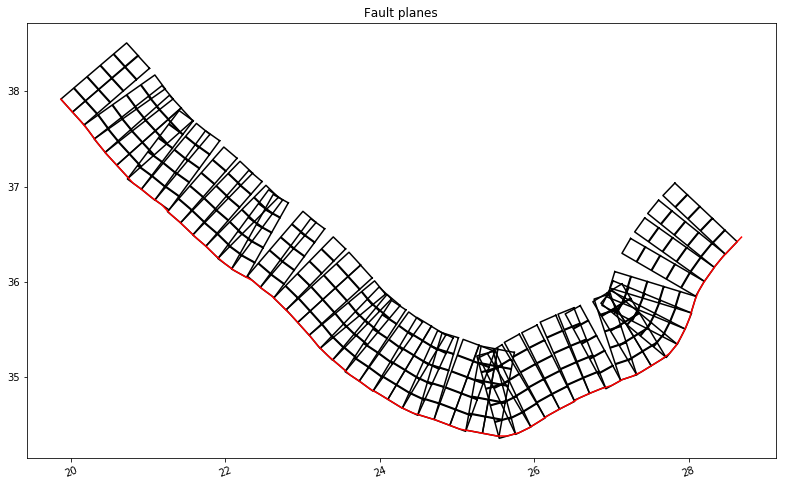

In [136]:
# creating and plotting subfaults in Geoclaw 
_, axes = plt.subplots(figsize=(16, 8))
fault.plot_subfaults(axes=axes, plot_rake=False)
plt.plot(lon, lat, 'r')

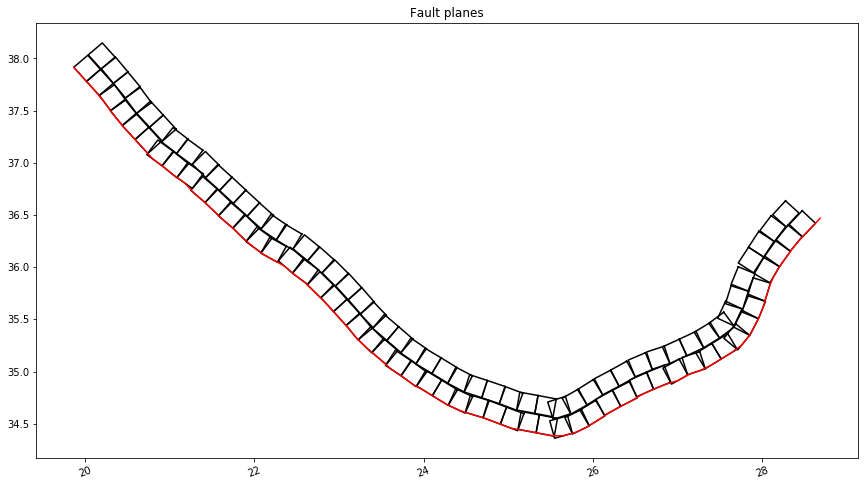

In [131]:
# creating and plotting subfaults in Geoclaw 
_, axes = plt.subplots(figsize=(16, 8))
fault.plot_subfaults(axes=axes, plot_rake=False)
plt.plot(lon, lat, 'r')

In [62]:
# calculating coordinates and strike angles of subfaults (20 km of length, 20 km of width, 2 layers)
[lons2old, lats2old, strikeold] = create_subfaults(lon, lat, 20000, 20000, 2)

In [63]:
# defining parameters of each subfault (in the example all parameters are uniformely distributed and do not 
# describe a real earthquake, they are used only for plotting the subfaults)
depth = 5*np.ones(len(lons2old))
length = 20*np.ones(len(lons2old))
width = 20*np.ones(len(lons2old))
dip = 15*np.ones(len(lons2old))
rake = 90*np.ones(len(lons2old))
slip = 10*np.ones(len(lons2old))

In [64]:
# writing the subfaults parameters in the csv file suitable for Geoclaw
with open("hellenicarc.csv", "w") as f:
    f.write("Longitude,Latitude,Depth,Length,Width,Strike,Dip,Rake,Slip\n")
    for long, latt, d, l, w, st, dipp, r, sl in zip(lons2old, lats2old, depth, length, width, strikeold, dip, rake, slip):
        f.write("{:.7},{:.7},{},{},{},{:.6},{},{},{}".format(long, latt, d, l, w, st, dipp, r, sl))
        f.write("\n")

In [152]:
def create_nonoverlapping_subfaults(lon, lat, D, W, nlayers):
    """
    Calculates the coordinates and the strike angles of subfaults with
    length D along the fault and width W perpendicular to the fault.
    As an input receives vectors of coordinates (in degrees) of the fault
    (longitude and latitude, respectfully; sorted by ascending longitude), 
    the length and the width of the subfault (in meters) and the desired 
    number of the subfault layers (in the direction perpendicular to the fault).
    """
    
    lons2 = []
    lats2 = []
    strike = []
    d = D/2

    # Calculates the coordinates and the strike angles of subfaults with
    # length D along the fault
    [lons2, lats2, strike] = points_on_line(lon, lat, d, D, lons2, lats2, strike)
    
    # when more than one layer are required
    if nlayers > 1:
        
        # find the number of subfaults in the first layer
        len_layer = len(lons2)
        
        # for each layer
        for j in range(2, nlayers + 1):
            
            # for each subfault in the layer
            dummy_lons2 = []
            dummy_lats2 = []
            dummy_strike = []
            
            for i in range(len_layer):
                
                # calculate coordinates of the points at the required distance 
                #from the previous layer perpendicular to the fault
                b = i + len(lons2) - len_layer
                dlons2, dlats2, backaz = geod.fwd(lons2[b], lats2[b], strike[b] + 90, W, radians=False)
                
                # save the coordinates and the strike angle of the points
                dummy_lons2.append(dlons2)
                dummy_lats2.append(dlats2)
                dummy_strike.append(strike[b])
                
            dummy_lons3 = []
            dummy_lats3 = []
            dummy_strike3 = []
            
        
            p1 = dummy_lons2[0]
            p2 = dummy_lats2[0]
            d = D
            dummy_lons3.append(p1)
            dummy_lats3.append(p2)
            dummy_strike3.append(dummy_strike[0])
            
             # Calculate the coordinates and the strike angles of subfaults with
            # length D along the line parallel to the fault line at the distance W from the fault line
            [dummy_lons3, dummy_lats3, dummy_strike3] = points_on_line(dummy_lons2, dummy_lats2, d, D,
                                                                       dummy_lons3, dummy_lats3, dummy_strike3)
            
                    
            lons2.extend(dummy_lons3)
            lats2.extend(dummy_lats3)
            strike.extend(dummy_strike3)
            
            len_layer = len(dummy_lons3)
                
    return lons2, lats2, strike

In [391]:
# calculating coordinates and strike angles of subfaults (20 km of length, 20 km of width, 5 layers)
[lons22, lats22, strike22] = create_nonoverlapping_subfaults(lon, lat, 20000, 20000, 5)

In [392]:
# defining parameters of each subfault (in the example all parameters are uniformely distributed and do not 
# describe a real earthquake, they are used only for plotting the subfaults)
depth = 5*np.ones(len(lons22))
length = 20*np.ones(len(lons22))
width = 20*np.ones(len(lons22))
dip = 15*np.ones(len(lons22))
rake = 90*np.ones(len(lons22))
slip = 10*np.ones(len(lons22))

In [393]:
# writing the subfaults parameters in the csv file suitable for Geoclaw
with open("hellenicarc.csv", "w") as f:
    f.write("Longitude,Latitude,Depth,Length,Width,Strike,Dip,Rake,Slip\n")
    for long, latt, d, l, w, st, dipp, r, sl in zip(lons22, lats22, depth, length, width, strike22, dip, rake, slip):
        f.write("{:.7},{:.7},{},{},{},{:.6},{},{},{}".format(long, latt, d, l, w, st, dipp, r, sl))
        f.write("\n")

In [394]:
# reading the csv file from Geoclaw
from clawpack.geoclaw import dtopotools, fgmax_tools
import os
CLAW = os.environ['CLAW']
subfault_fname = 'hellenicarc.csv'
input_units = {"length":"km", "width":"km", "depth":"km", "slip":"m"}
fault = dtopotools.CSVFault()
fault.read(subfault_fname, input_units=input_units)

In [153]:
def points_on_line(lon, lat, d, D, lons2, lats2, strike):
    """
    Calculates the coordinates and the strike angles of subfaults with
    length D along the fault.
    As an input receives vectors of coordinates (in degrees) of the fault
    (longitude and latitude, respectfully; sorted by ascending longitude), 
    distance to the first subfault location, the length of the subfault (in meters),
    vectors of the coordinates and the strike angles of the subfaults.
    """
    i = 0
    p1 = lon[0]
    p2 = lat[0]
    n = len(lon) - 2
    
    while True:
        # calculate distance and angles from current position to the next point along the fault
        az1, az2, dist = geod.inv(p1, p2, lon[i + 1], lat[i + 1], radians=False)
        
        # if the distance to the next point is greater than the required distance
        if dist > d:
            
            # calculate coordinates of the point on the fault at the required distance 
            # in the direction of the next point
            p1, p2, backaz = geod.fwd(p1, p2, az1, d, radians=False)
            
            # save the coordinates and the strike angle of the subfault
            lons2.append(p1)
            lats2.append(p2)
            strike.append(az2)
            d = D
            
        # if the distance to the next point is smaller than the required distance    
        else:
            
            # move the current position to the next point and calculate the remaining 
            # distance
            d = d - dist
            i = i + 1 
            p1 = lon[i]
            p2 = lat[i]
            
        if i > n:
            break
            
    return lons2, lats2, strike

# Area Sampling

In [169]:
lons22

[19.943647168045803,
 20.094053973006947,
 20.237139935528436,
 20.371521502262475,
 20.516478552974043,
 20.667762462233146,
 20.82104192673973,
 20.99830315986207,
 21.17838742123914,
 21.334436952865882,
 21.499323151591163,
 21.66221674815879,
 21.826331888105912,
 21.992439583642692,
 22.17644865038545,
 22.368883229849967,
 22.541078108391346,
 22.705879250035768,
 22.86208268600498,
 23.01076861792445,
 23.155974155677413,
 23.30770175815883,
 23.474822141122285,
 23.642282645964652,
 23.82289884307779,
 24.010557091387142,
 24.19772061639878,
 24.391432576593143,
 24.598193898543084,
 24.80509325315188,
 25.009345993728623,
 25.222528277383148,
 25.436462599732085,
 25.65252387738851,
 25.85871894434614,
 26.048800064967743,
 26.23333114902409,
 26.426725857571327,
 26.617444767614664,
 26.81895734988041,
 27.025325605888536,
 27.223709884951255,
 27.422035651485103,
 27.609651590478663,
 27.781703094309144,
 27.90464075179969,
 27.997684840258508,
 28.064963216240127,
 28.1479

In [570]:
(82.29 - 81.82)/81.82 * 100

0.5744316792960317

In [571]:
(8.855 - 5.692)/5.692 * 100

55.56921995783556

In [572]:
(8.712 - 8.546)/8.546 * 100

1.9424292066463886

In [244]:
# converting the input from the lists into the arrays 
sflons = np.array(lons22)
sflats = np.array(lats22)
sfstrike = np.array(strike22)

In [248]:
sfstrike.size

244

In [247]:
# inserting NaNs at the end of each row of the subfaults
for i in range(2, len(sflons)):
    if sflons[i] - sflons[i-1] < 0: 
        sflons = np.insert(sflons, i, np.nan)
        sflats = np.insert(sflats, i, np.nan)
        sfstrike = np.insert(sfstrike, i, np.nan)

In [464]:
# number of subfaults along the fault
ns = 5

# number of subfaults in the strike direction
nw = 2

# random sampling of the index of the last subfault in the first row of the sampled area
idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))

# creating vectors of coordinates and strike angles of the first row of the subfaults of the sampled area
dummy_sflons = sflons[idx-ns+1:idx+1]
dummy_sflats = sflats[idx-ns+1:idx+1]
dummy_sfstrike = sfstrike[idx-ns+1:idx+1]  

# if the vector of the coordinates includes an end of a layer of the subfaults, sample another index
# and create new vectors of coordinates and strike angles of the first layer of the 
# subfaults of the sampled area
if np.isnan(dummy_sflons).any():
    idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
    dummy_sflons = sflons[idx-ns+1:idx+1]
    dummy_sflats = sflats[idx-ns+1:idx+1]
    dummy_sfstrike = sfstrike[idx-ns+1:idx+1]   

In [291]:
dummy_sflons = sflons[idx-1:idx+1]

In [295]:
if np.isnan(dummy_sflons).any():
    idx = 5

In [305]:
idx

45

In [311]:
dummy_sflons[0]

27.422035651485103

In [312]:
sflons[idx]

27.90464075179969

In [438]:
# find indices of nans (ends of rows of subfaults)
ndx = np.argwhere(np.isnan(sflons))
ndx = [int(i) for i in ndx]
ndx.append(len(sflons))

In [319]:
from math import *
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) usine haversine formula
    (which is said to be better for small distances)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    dist = 6371000* c
    return dist

In [473]:
# number of subfaults along the fault
ns = 4

# number of subfaults in the strike direction
nw = 1

# random sampling of the index of the last subfault in the first row of the sampled area
idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))

# creating vectors of coordinates and strike angles of the first row of the subfaults of the sampled area
dummy_sflons = sflons[idx-ns+1:idx+1]
dummy_sflats = sflats[idx-ns+1:idx+1]
dummy_sfstrike = sfstrike[idx-ns+1:idx+1]  

# if the vector of the coordinates includes an end of a layer of the subfaults, sample another index
# and create new vectors of coordinates and strike angles of the first layer of the 
# subfaults of the sampled area
if np.isnan(dummy_sflons).any():
    idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
    dummy_sflons = sflons[idx-ns+1:idx+1]
    dummy_sflats = sflats[idx-ns+1:idx+1]
    dummy_sfstrike = sfstrike[idx-ns+1:idx+1]   

# if more than one layer of the subfaults is required
if nw > 1:
    
    # calculate coordinates of the point at the required distance 
    #from the last point of the first layer perpendicular to the fault
    plons2, plats2, pbackaz = geod.fwd(sflons[idx], sflats[idx], sfstrike[idx] + 90, W, radians=False)
    
    # find the current row of the subfaults
    if idx < ndx[0]:
        k = 0
    elif idx < ndx[1]:
        k = 1
    elif idx < ndx[2]:
        k = 2
    elif idx < ndx[3]:
        k = 3
    else:
        k = 4
    
    # find the distance from the above point to all the subfaults in the next row
    ddist = np.zeros(len(sflons)) + D
    for i in range (ndx[k] + 1, ndx[k + 1]):
        ddist[i] = haversine(plons2, plats2, sflons[i], sflats[i])
    
    # find the minimal distance (the closest subfault)
    pind = np.argmin(ddist)
    
    # add the coordinates of the next layer of the subfaults to the vector of the 
    # previous layers coordinates
    dummy_sflons = np.append(dummy_sflons, sflons[pind-ns+1:pind+1])
    dummy_sflats = np.append(dummy_sflats, sflats[pind-ns+1:pind+1])
    dummy_sfstrike = np.append(dummy_sfstrike, sfstrike[pind-ns+1:pind+1])

In [465]:
# calculate coordinates of the point at the required distance 
#from the last point of the first layer perpendicular to the fault
               
plons2, plats2, pbackaz = geod.fwd(sflons[idx], sflats[idx], sfstrike[idx] + 90, W, radians=False)

In [466]:
# find the current row of the subfaults
if idx < ndx[0]:
    k = 0
elif idx < ndx[1]:
    k = 1
elif idx < ndx[2]:
    k = 2
elif idx < ndx[3]:
    k = 3
else:
    k = 4

In [467]:
# find the distance from the above point to all the subfaults in the next row
ddist = np.zeros(len(sflons)) + D
for i in range (ndx[k] + 1, ndx[k + 1]):
    ddist[i] = haversine(plons2, plats2, sflons[i], sflats[i])

In [468]:
# find the minimal distance (the closest subfault)
pind = np.argmin(ddist)

In [469]:
# add the coordinates of the next layer of the subfaults to the vector of the 
# previous layers coordinates
dummy_sflons = np.append(dummy_sflons, sflons[pind-ns+1:pind+1])
dummy_sflats = np.append(dummy_sflats, sflats[pind-ns+1:pind+1])
dummy_sfstrike = np.append(dummy_sfstrike, sfstrike[pind-ns+1:pind+1])

In [542]:
# number of subfaults along the fault
ns = 8

# number of subfaults in the strike direction
nw = 3

# random sampling of the index of the last subfault in the first row of the sampled area
#idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
idx = 136
#idx = 118

# creating vectors of coordinates and strike angles of the first row of the subfaults of the sampled area
dummy_sflons = sflons[idx-ns+1:idx+1]
dummy_sflats = sflats[idx-ns+1:idx+1]
dummy_sfstrike = sfstrike[idx-ns+1:idx+1]  

# if the vector of the coordinates includes an end of a layer of the subfaults, sample another index
# and create new vectors of coordinates and strike angles of the first layer of the 
# subfaults of the sampled area
if np.isnan(dummy_sflons).any():
    idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
    dummy_sflons = sflons[idx-ns+1:idx+1]
    dummy_sflats = sflats[idx-ns+1:idx+1]
    dummy_sfstrike = sfstrike[idx-ns+1:idx+1]   

# if more than one layer of the subfaults is required    
if nw > 1:
 
    # find the current row of the subfaults
    if idx < ndx[0]:
        k = 0
    elif idx < ndx[1]:
        k = 1
    elif idx < ndx[2]:
        k = 2
    elif idx < ndx[3]:
        k = 3
    else:
        k = 4
    
    
    for j in range (2, nw + 1):
        # calculate coordinates of the point at the distance W
        # from the last point of the first layer perpendicular to the fault 
        plons2, plats2, pbackaz = geod.fwd(sflons[idx], sflats[idx], sfstrike[idx] + 90, W*(j-1), radians=False)

        # find the distance from the above point to all the subfaults in the next row
        ddist = np.zeros(len(sflons)) + D
        for i in range (ndx[k] + 1, ndx[k + 1]):
            ddist[i] = haversine(plons2, plats2, sflons[i], sflats[i])

        # find the minimal distance (the closest subfault)    
        pind = np.argmin(ddist)
        
        # add the coordinates of the next layer of the subfaults to the vector of the 
        # previous layers coordinates
        dummy_sflons = np.append(dummy_sflons, sflons[pind-ns+1:pind+1])
        dummy_sflats = np.append(dummy_sflats, sflats[pind-ns+1:pind+1])
        dummy_sfstrike = np.append(dummy_sfstrike, sfstrike[pind-ns+1:pind+1])
        
        # go to the next layer
        k = k + 1

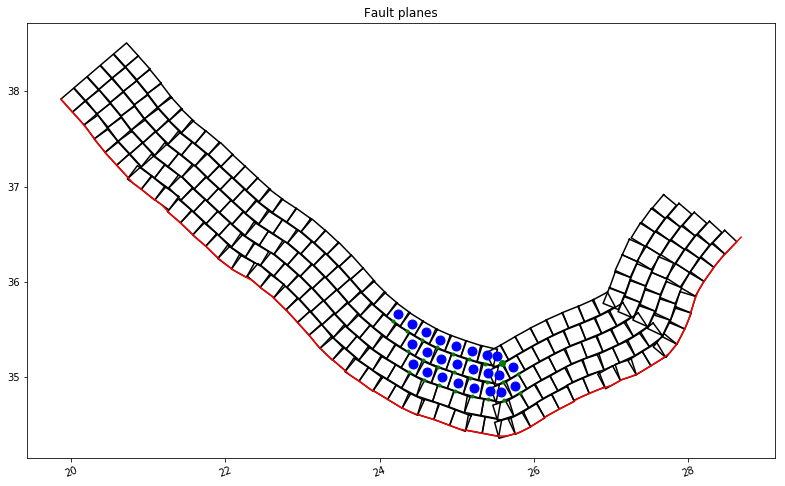

In [543]:
# calculating the central points of the selected subfaults (for plotting only)
dlons2 = []
dlats2 = []
for i in range(len(dummy_sflons)):
    ddlons2, ddlats2, backaz = geod.fwd(dummy_sflons[i], dummy_sflats[i], dummy_sfstrike[i] + 90, W/2, radians=False)
    dlons2.append(ddlons2)
    dlats2.append(ddlats2)

# creating and plotting subfaults in Geoclaw, the fault and the central points of the selected subfaults
_, axes = plt.subplots(figsize=(16, 8))
fault.plot_subfaults(axes=axes, plot_rake=False)
plt.plot(lon, lat, 'r')
plt.plot(dummy_sflons, dummy_sflats, 'g.')
plt.plot(dlons2, dlats2, 'b.', markersize = 18)
plt.plot(plons2, plats2, 'g.', markersize = 12)

In [439]:
# indices of the ends of rows
ndx

[52, 103, 152, 199, 244]

In [507]:
# for nw = 3, ns = 8
idx

118

In [607]:
nw = 5

In [608]:
ndx[len(ndx)-nw]

52

In [454]:
np.random.choice(np.arange(0, 3),30)

array([0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 2, 0, 1, 2, 2])

In [528]:
541.02/145.38

3.7214197276104004

In [567]:
# number of subfaults along the fault
ns = 10

# number of subfaults in the strike direction
nw = 4

# random sampling of the index of the last subfault in the first row of the sampled area
idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
#idx = 136

# creating vectors of coordinates and strike angles of the first row of the subfaults of the sampled area
dummy_sflons = sflons[idx-ns+1:idx+1]
dummy_sflats = sflats[idx-ns+1:idx+1]
dummy_sfstrike = sfstrike[idx-ns+1:idx+1]  

# if the vector of the coordinates includes an end of a layer of the subfaults, sample another index
# and create new vectors of coordinates and strike angles of the first layer of the 
# subfaults of the sampled area
if np.isnan(dummy_sflons).any():
    idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
    dummy_sflons = sflons[idx-ns+1:idx+1]
    dummy_sflats = sflats[idx-ns+1:idx+1]
    dummy_sfstrike = sfstrike[idx-ns+1:idx+1]   

# if more than one layer of the subfaults is required    
if nw > 1:
    
    # find the current row of the subfaults
    if idx < ndx[0]:
        k = 0
    elif idx < ndx[1]:
        k = 1
    elif idx < ndx[2]:
        k = 2
    elif idx < ndx[3]:
        k = 3
    else:
        k = 4

    pind = idx
    
    for j in range (2, nw + 1):
        
        # calculate coordinates of the point at the distance W
        # from the last point of the previous layer perpendicular to the fault (find the point on the 
        # next row closest to the last point of the current row)
        plons2, plats2, pbackaz = geod.fwd(sflons[pind], sflats[pind], sfstrike[pind] + 90, W, radians=False)

        # find the distance from the above point to all the subfaults in the next row
        ddist = np.zeros(len(sflons)) + D
        for i in range (ndx[k] + 1, ndx[k + 1]):
            ddist[i] = haversine(plons2, plats2, sflons[i], sflats[i])

        # find the minimal distance (the closest subfault)    
        pind = np.argmin(ddist)
        
        # add the coordinates of the next layer of the subfaults to the vector of the 
        # previous layers coordinates
        dummy_sflons = np.append(dummy_sflons, sflons[pind-ns+1:pind+1])
        dummy_sflats = np.append(dummy_sflats, sflats[pind-ns+1:pind+1])
        dummy_sfstrike = np.append(dummy_sfstrike, sfstrike[pind-ns+1:pind+1])
        
        # go to the next layer
        k = k + 1

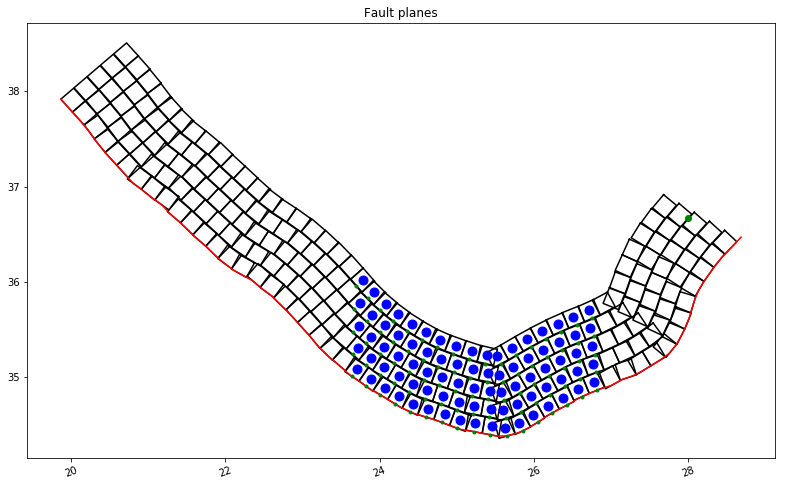

In [603]:
# calculating the central points of the selected subfaults (for plotting only)
dlons2 = []
dlats2 = []
for i in range(len(dummy_sflons)):
    ddlons2, ddlats2, backaz = geod.fwd(dummy_sflons[i], dummy_sflats[i], dummy_sfstrike[i] + 90, W/2, radians=False)
    dlons2.append(ddlons2)
    dlats2.append(ddlats2)

# creating and plotting subfaults in Geoclaw, the fault and the central points of the selected subfaults
_, axes = plt.subplots(figsize=(16, 8))
fault.plot_subfaults(axes=axes, plot_rake=False)
plt.plot(lon, lat, 'r')
plt.plot(dummy_sflons, dummy_sflats, 'g.')
plt.plot(dlons2, dlats2, 'b.', markersize = 18)
plt.plot(plons2, plats2, 'g.', markersize = 12)

In [552]:
idx

88

In [605]:
def area_sampling(lons, lats, strike, ns, nw, D, W):
    
    """
    Samples randomly an area of the desired size from all the subfaults.
    As an input receives vectors of coordinates (in degrees, longitude and 
    latitude, respectfully) and the strike angles of all the subfaults,
    desired number of subfaults along the fault, ns,desired number of subfaults
    in the direction perpendicular to the fault, nw, the length, D, and the width, W, of the subfaults.
    """
    
    # converting the input from the lists into the arrays 
    sflons = np.array(lons)
    sflats = np.array(lats)
    sfstrike = np.array(strike)
    
    # inserting NaNs at the end of each row of the subfaults
    for i in range(2, len(sflons)):
        if sflons[i] - sflons[i-1] < 0: 
            sflons = np.insert(sflons, i, np.nan)
            sflats = np.insert(sflats, i, np.nan)
            sfstrike = np.insert(sfstrike, i, np.nan)
            
    
    # finding indices of nans (ends of rows of subfaults) and adding the index of the end of the last row
    ndx = np.argwhere(np.isnan(sflons))
    ndx = [int(i) for i in ndx]
    ndx.append(len(sflons))

    # random sampling of the index of the last subfault in the first row of the sampled area
    idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
  
    # creating vectors of coordinates and strike angles of the first row of the subfaults of the sampled area
    dummy_sflons = sflons[idx-ns+1:idx+1]
    dummy_sflats = sflats[idx-ns+1:idx+1]
    dummy_sfstrike = sfstrike[idx-ns+1:idx+1]  

    # if the vector of the coordinates includes an end of a layer of the subfaults, sample another index
    # and create new vectors of coordinates and strike angles of the first layer of the 
    # subfaults of the sampled area
    while np.isnan(dummy_sflons).any():
        idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
        dummy_sflons = sflons[idx-ns+1:idx+1]
        dummy_sflats = sflats[idx-ns+1:idx+1]
        dummy_sfstrike = sfstrike[idx-ns+1:idx+1]   

    # if more than one layer of the subfaults is required
    if nw > 1:
        
        # find the current row of the subfaults
        if idx < ndx[0]:
            k = 0
        elif idx < ndx[1]:
            k = 1
        elif idx < ndx[2]:
            k = 2
        elif idx < ndx[3]:
            k = 3
        else:
            k = 4

        pind = idx

        for j in range (2, nw + 1):
            # calculate coordinates of the point at the distance W
            # from the last point of the previous layer perpendicular to the fault (find the point on the 
            # next row closest to the last point of the current row)
            plons2, plats2, pbackaz = geod.fwd(sflons[pind], sflats[pind], sfstrike[pind] + 90, W, radians=False)

            # find the distance from the above point to all the subfaults in the next row
            ddist = np.zeros(len(sflons)) + D
            for i in range (ndx[k] + 1, ndx[k + 1]):
                ddist[i] = haversine(plons2, plats2, sflons[i], sflats[i])

            # find the minimal distance (the closest subfault)
            pind = np.argmin(ddist)
            
            # add the coordinates of the next layer of the subfaults to the vector of the 
            # previous layers coordinates
            dummy_sflons = np.append(dummy_sflons, sflons[pind-ns+1:pind+1])
            dummy_sflats = np.append(dummy_sflats, sflats[pind-ns+1:pind+1])
            dummy_sfstrike = np.append(dummy_sfstrike, sfstrike[pind-ns+1:pind+1])

            # go to the next layer
            k = k + 1
            
    return dummy_sflons, dummy_sflats, dummy_sfstrike

In [602]:
# Sampling randomly an area of 340x100 km
dummy_sflons, dummy_sflats, dummy_sfstrike = area_sampling(lons22, lats22, strike22, 17, 5)

In [597]:
idx = 103

In [598]:
dummy_sflons = sflons[idx-ns+1:idx+1]
dummy_sflats = sflats[idx-ns+1:idx+1]
dummy_sfstrike = sfstrike[idx-ns+1:idx+1]  

In [599]:
while np.isnan(dummy_sflons).any():
    idx = int(np.random.choice(np.arange(ns-1, ndx[len(ndx)-nw]),1))
    dummy_sflons = sflons[idx-ns+1:idx+1]
    dummy_sflats = sflats[idx-ns+1:idx+1]
    dummy_sfstrike = sfstrike[idx-ns+1:idx+1]   

In [600]:
idx

86

In [606]:
W

20000